In [68]:
from bayes_opt import BayesianOptimization
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import minimize
import pandas as pd
from scipy.interpolate import Rbf 
from pykrige.ok import OrdinaryKriging

In [69]:
df = pd.read_excel("数据集.xlsx")
df

,x(m),y(m),As (μg/g)
0,74,781,7.84
1,1373,731,5.93
2,1321,1791,4.90
3,0,1787,6.56
4,1049,2127,6.35
...,...,...,...
314,6924,5696,6.47
315,4678,3765,6.47
316,6182,2005,4.79
317,5985,2567,7.56


In [70]:
X = df.iloc[:, 0]
Y = df.iloc[:, 1]
Z = df.iloc[:, 2]

x_min = X.min()
x_max = X.max()
y_min = Y.min()
y_max = Y.max()

X = X/10000
Y = Y/10000
Z = Z/10000

In [71]:
n = 6
m = 4
def func(x):
	ans = 0
	for i in range(n):
		ki = x[m*i]
		xi = x[m*i+1]
		yi = x[m*i+2]
		sig = x[m*i+3]
		ans += ki*np.exp((-(X-xi)**2-(Y-yi)**2)/sig)
	loss = np.sum(0.5*(ans-Z)**2)
	return loss

In [72]:
df.sort_values(by='As (μg/g)', ascending=False).head(10)

,x(m),y(m),As (μg/g)
83,18134,10046,30.13
177,12696,3024,23.72
28,4742,7293,21.87
29,4948,7293,18.38
40,6869,7286,16.58
5,1647,2728,14.08
309,9095,16414,11.68
15,4777,4897,11.45
81,18738,10921,10.99
271,9277,16148,10.97


In [73]:
b_init = [
        0, 1.8, 1, 2,
        0, 1.2, 0.3, 2,
        0, 0.47, 0.7, 2,
        0, 0.49, 0.7, 2,
        0, 0.16, 0.27, 2,
        0, 0.90, 1.64, 2
      ]
method_list = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B']

# cons=(
#     {'type':'ineq','fun':lambda x: 3*x[0]+3*x[1]+x[2]-1},
#     {'type':'ineq','fun':lambda x: 4*x[0]+3*x[1]+x[2]-1},
#     {'type':'ineq','fun':lambda x: -x[0]-x[1]-x[2]-1}
# )

bd = [(-10000, 10000), (x_min, x_max), (y_min, y_max), (0, 10000),
      (-10000, 10000), (x_min, x_max), (y_min, y_max), (0, 10000),
      (-10000, 10000), (x_min, x_max), (y_min, y_max), (0, 10000),
      (-10000, 10000), (x_min, x_max), (y_min, y_max), (0, 10000),
      (-10000, 10000), (x_min, x_max), (y_min, y_max), (0, 10000),
      (-10000, 10000), (x_min, x_max), (y_min, y_max), (0, 10000)
        ]
res = minimize(fun=func, x0=b_init, method=method_list[0], bounds=bd)

In [74]:
pp = pd.DataFrame(data=res.x.reshape(-1, m), columns=['k', 'x', 'y', 'sig'])
pp

,k,x,y,sig
0,0.000958,2.039533,0.939489,2.291599
1,-0.000896,1.629716,0.765860,2.385869
2,0.000518,0.000034,1.116599,2.715231
3,0.000360,0.635658,0.003379,4.512183
4,0.000191,0.234321,0.280444,3.065431
5,0.001056,0.997139,1.649491,0.012474


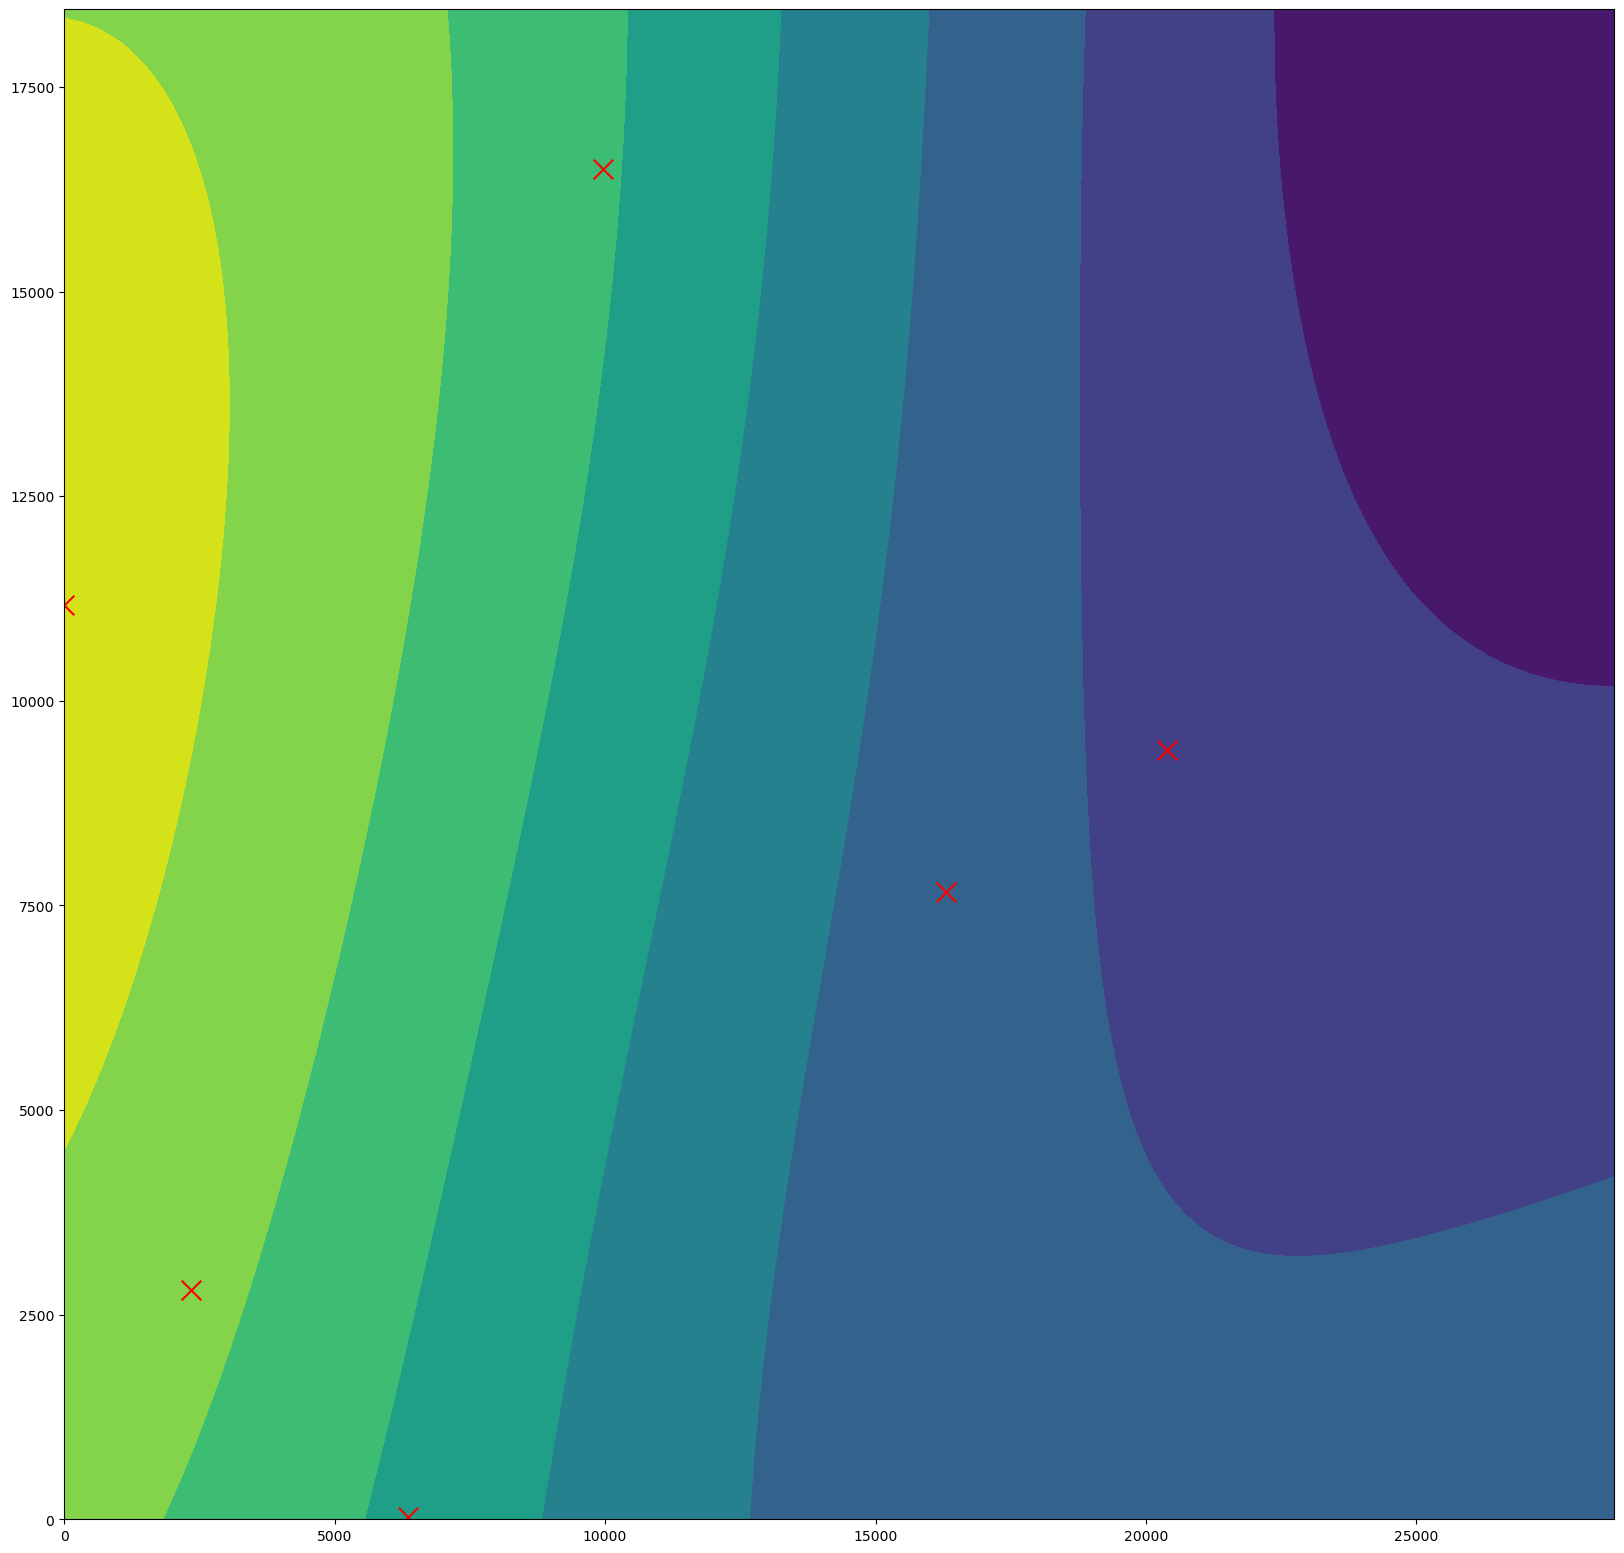

In [75]:
plt.figure(figsize=(20, 20), dpi=100)

lons = df.iloc[:, -3]
lats = df.iloc[:, -2]
data = df.iloc[:, -1]

grid_x = np.linspace(0, x_max, 500)
grid_y = np.linspace(0, y_max, 500)

OK = OrdinaryKriging(lons, lats, data, variogram_model='gaussian', nlags=6)
z1, ss1 = OK.execute('grid', grid_x, grid_y)

xgrid, ygrid = np.meshgrid(grid_x, grid_y)

plt.contourf(xgrid, ygrid, z1)
plt.scatter(x=pp['x'][0]*10000, y=pp['y'][0]*10000, c='red', marker='x', s=200)
plt.scatter(x=pp['x'][1]*10000, y=pp['y'][1]*10000, c='red', marker='x', s=200)
plt.scatter(x=pp['x'][2]*10000, y=pp['y'][2]*10000, c='red', marker='x', s=200)
plt.scatter(x=pp['x'][3]*10000, y=pp['y'][3]*10000, c='red', marker='x', s=200)
plt.scatter(x=pp['x'][4]*10000, y=pp['y'][4]*10000, c='red', marker='x', s=200)
plt.scatter(x=pp['x'][5]*10000, y=pp['y'][5]*10000, c='red', marker='x', s=200)
plt.show()